<h1 style="color:blue; font-size:36px;">Projet Machine Learning 4A</h1>

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [251]:
data=pd.read_csv('global-data-on-sustainable-energy.csv')
data.shape
#data['Value_co2_emissions_kt_by_country'].groupby(['Entity'])
data['Value_co2_emissions_kt_by_country'].groupby(data['Entity']).sum().sort_values(ascending=False)
data.isna().sum().sum()


6978

In [253]:
Value_co2_emissions_kt_by_country=data['Value_co2_emissions_kt_by_country']
data.drop(['Value_co2_emissions_kt_by_country'],axis=1,inplace=True)

data.isna().sum().sum()

6550

### <span style="color:blue">**I. Nettoyage des données** </span>

#### <span style="color:blue">**I.1 Suppression des NAN** </span>

In [254]:
data.shape

(3649, 20)

#### Grace à la statistique "count", nous constatons que les variables n'ont pas toutes le meme nombre d'observations indinquant ainsi la présence de données manquantes

In [255]:
(data.isna().sum()/data.shape[0]*100).sort_values(ascending=False)

Renewables (% equivalent primary energy)                            58.563990
Financial flows to developing countries (US $)                      57.248561
Renewable-electricity-generating-capacity-per-capita                25.513839
gdp_growth                                                           8.687312
gdp_per_capita                                                       7.728145
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          5.672787
Renewable energy share in the total final energy consumption (%)     5.316525
Access to clean fuels for cooking                                    4.631406
Electricity from nuclear (TWh)                                       3.453001
Low-carbon electricity (% electricity)                               1.151000
Electricity from fossil fuels (TWh)                                  0.575500
Electricity from renewables (TWh)                                    0.575500
Access to electricity (% of population)                         

#### Nous allons retirer les variables Renewables, Financial flows to developing countries et Renewable-electricity-generating-capacity-per-capita en raison de leur taux de données manquantes, situé entre 25 et 60 %. Ensuite, nous éliminerons tous les individus ayant des valeurs non disponibles (NaN) pour les variables restantes. il nous reste ainsi 2868 individus avec 18 variables

In [256]:
data.drop(['Renewable-electricity-generating-capacity-per-capita','Financial flows to developing countries (US $)','Renewables (% equivalent primary energy)'],axis=1,inplace=True)

In [257]:
data.shape

(3649, 17)

In [258]:
data.dropna(axis=0,inplace=True)
data.shape

(2889, 17)

#### <span style="color:blue">**I.2 Conversion des variables 'Year' et 'Entity'* </span>

In [259]:
data['Year'] = data['Year'].astype('category')
data.rename(columns={data.columns[14]: 'Density'}, inplace=True) #renommer la colonne Density pour faciliter l'accés à la variable
data['Density']= pd.to_numeric(data['Density'], errors='coerce')

data.dtypes

Entity                                                                object
Year                                                                category
Access to electricity (% of population)                              float64
Access to clean fuels for cooking                                    float64
Renewable energy share in the total final energy consumption (%)     float64
Electricity from fossil fuels (TWh)                                  float64
Electricity from nuclear (TWh)                                       float64
Electricity from renewables (TWh)                                    float64
Low-carbon electricity (% electricity)                               float64
Primary energy consumption per capita (kWh/person)                   float64
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          float64
gdp_growth                                                           float64
gdp_per_capita                                                       float64

### <span style="color:blue">**II. Analyse unidimentionnelle** </span>

#### <span style="color:blue">*II.1 Variables qualitatives* </span>

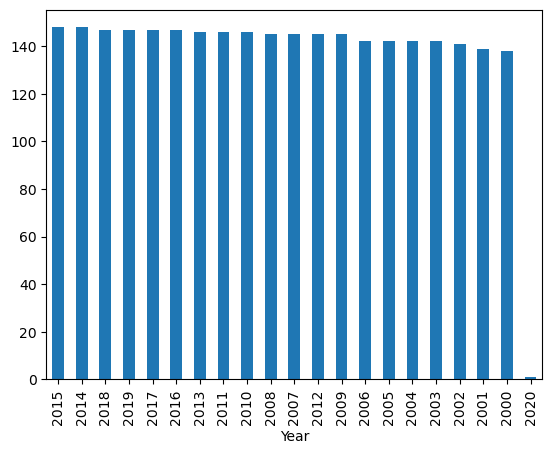

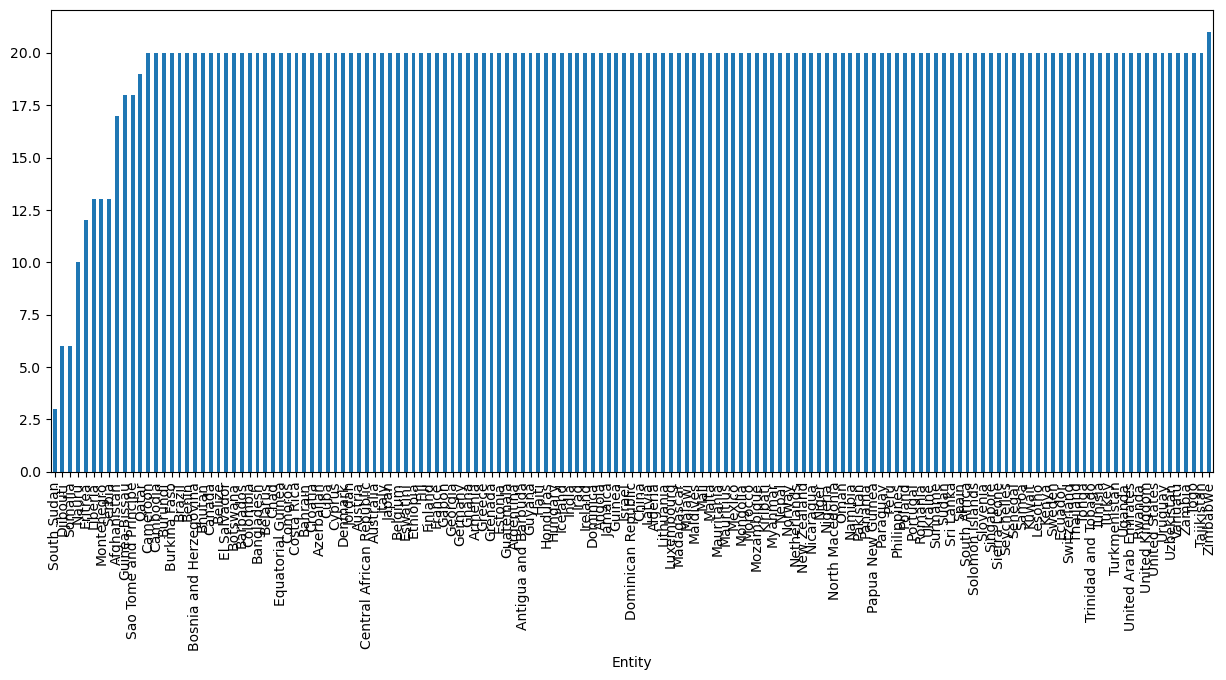

In [260]:
data['Year'].value_counts().plot.bar()
plt.figure(figsize=(15,6))

data['Entity'].value_counts().sort_values(ascending=True).plot.bar()
plt.tick_params(axis='x', rotation=90)

#### Nous observons des disparités dans le nombre d'observations pour chaque année. Les années les plus anciennes présentent moins d'observations que les plus récentes, ce qui peut indiquer une amélioration dans la collecte des données au fil du temps. De plus, il est important de noter que nous n'avons pas le même nombre d'observations pour chaque pays. Certains pays, comme le South Sudan, ont significativement moins d'observations par rapport aux autres, ce qui pourrait refléter des lacunes dans la disponibilité des données ou des déficultés dans la collecte d'informations dans ces régions

#### <span style="color:blue">*II.2 Variables quantitatives* </span>

In [261]:
data1=data.iloc[:,2:] #On extrait que les variables quantitatives

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Access to electricity (% of population)'),
  Text(1, 0, 'Access to clean fuels for cooking'),
  Text(2, 0, 'Renewable energy share in the total final energy consumption (%)'),
  Text(3, 0, 'Electricity from fossil fuels (TWh)'),
  Text(4, 0, 'Electricity from nuclear (TWh)'),
  Text(5, 0, 'Electricity from renewables (TWh)'),
  Text(6, 0, 'Low-carbon electricity (% electricity)'),
  Text(7, 0, 'Primary energy consumption per capita (kWh/person)'),
  Text(8, 0, 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'),
  Text(9, 0, 'gdp_growth'),
  Text(10, 0, 'gdp_per_capita'),
  Text(11, 0, 'Density'),
  Text(12, 0, 'Latitude'),
  Text(13, 0, 'Longitude')])

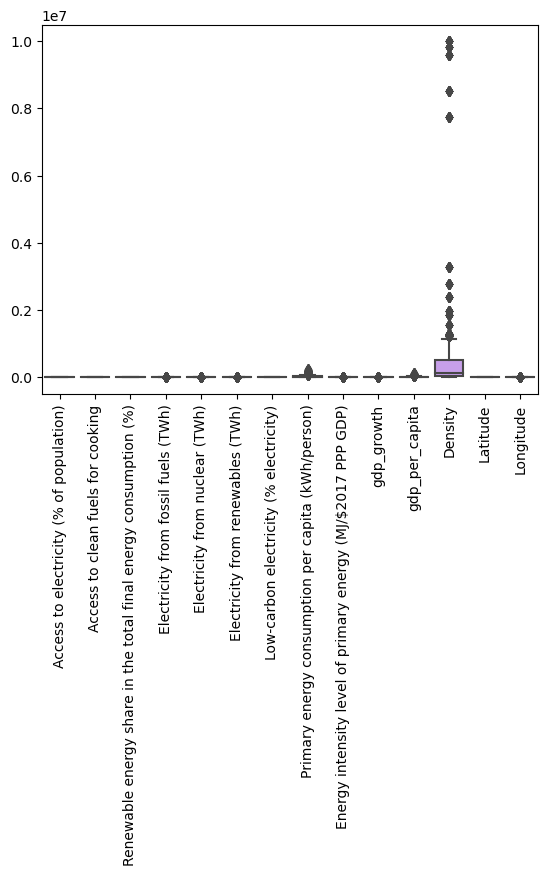

In [262]:
sns.boxplot(data1)
plt.xticks(rotation=90)

#### Nous notons que nos variables présentent non seulement  unités de mesure variées, mais aussi des échelles différentes. Certaines variables ont une importance relative plus élevée que d'autres. Afin d'homogénéiser nos données on va les centrer et les reduire

In [264]:
mean=data1.mean()
std=data1.std()
data1=(data1-mean)/std
sns.boxplot(data1)
plt.xticks(rotation=90)

TypeError: Could not convert ['6060606060606060606060606060606060181818181818181818181818181818181818181826262626262626262626262626262626262626262232232232232232232232232232232232232232232232232232232232231717171717171717171717171717171717171717104104104104104104104104104104104104104104104104104104104104333333333333333333331091091091091091091091091091091091091091091091091091091091091231231231231231231231231231231231231231231231231231231231232,2392,2392,2392,2392,2392,2392,2392,2392,2392,2392,2392,2392,2392,2392,2392,2392,2392,2392,2392,2391,2651,2651,2651,2651,2651,2651,2651,2651,2651,2651,2651,2651,2651,2651,2651,2651,2651,2651,2651,26566866866866866866866866866866866866866866866866866866866866847474747474747474747474747474747474747473833833833833833833833833833833833833833833833833833833833831717171717171717171717171717171717171717108108108108108108108108108108108108108108108108108108108108202020202020202020202020202020202020202064646464646464646464646464646464646464644444444444444444444425252525252525252525252525252525252525257676767676767676767676767676767676767676463463463463463463463463463463463463463463463463463463463463959595959595959595959595959595959595959556565656565656565656565656565656565656564444444444444444444488888888888888888888131313131313131313131313131313131313131315315315315315315315315315315315315315315315315315315315315346464646464646464646464646464646464646464674674674674674674674674674674674674674674674674674674674671001001001001001001001001001001001001001001001001001001001007373737373737373737373737373737373737373106106106106106106106106106106106106106106106106106106106106131131131131131131131131131131131131131131131131131131131131137137137137137137137137137137137137137137137137137137137137434343434343969696969696969696969696969696969696969622522522522522522522522522522522522522522522522522522522522571717171717171717171717171717171717171713133133133133133133133133133133133133133133133133133133133135050505050505050505050505050505050505050353535353535353535353535313131313131313131313131313131313131313167676767676767676767676767676767676767671151151151151151151151151151151151151151151151151151151151154949494949494949494949494949494949494949181818181818181818181818181818181818181811911911911911911911911911911911911911911911911911911911911999999999999999999999575757575757575757575757575757575757575724024024024024024024024024024024024024024024024024024024024013713713713713713713713713713713713713713713713713713713713781818181818181818181818181818181818181813313313313313313313313313313313313313313313313313313313313311671671671671671671671671671671671671671671671671671671671675353535353535353535353535353535353535353707070707070707070707070707070707070444444444444444444444144144144144144144144144144144144144144144144144144144144148989898989898989898989898989898989898989107107107107107107107107107107107107107107107107107107107107333333333333333333334644644644644644644644644644644644644644644644644644644644649393939393939393939393939393939393939393737373737373737373737373737373737373737340040040040040040040040040040040040040040040040040040040040020620620620620620620620620620620620620620620620620620620620627327327327327327327327327327327327327327327327327327327327334734734734734734734734734734734734734734734734734734734734711511511511511511511511511511511511511511511511511511511511594949494949494949494949494949494949494941471471471471471471471471471471471471471471471471471471471472402402402402402402402402402402402402402402402402402402402403030303030303030303030303030303030303030717171717171717171717171717171717171717153535353535353535353535353434343434343434343434343434343434343434324224224224224224224224224224224224224224224224224224224224248484848484848484848484848484848484848482032032032032032032032032032032032032032032032032032032032031,8021,8021,8021,8021,8021,8021,8021,8021,8021,8021,8021,8021,8021,8021,8021,8021,8021,8021,8021,80217171717171717171717171717171717171717171,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,38055555555555555555555626626626626626626626626626626626626626626626626626626626626666666666666666666666666666666666666666622222222222222222222474747474747474747474747478383838383838383838383838383838383838383404040404040404040404040404040404040404083838383838383838383838383838383838383833333333333333333333354154154154154154154154154154120320320320320320320320320320320320320320320320320320320320350850850850850850850850850850850850850850850850850850850850818181818181818181818181818181818181818185555555555555555555555555555555555555555191919191919191919191919191919191919191922622622622622622622622622622622622622622622622622622622622683838383838383838383838383838383838383831515151515151515151515151515151515151515161616161616161616161616161616161616161628728728728728728728728728728728728728728728728728728728728758585858585858585858585858585858585858582020202020202020202020202020202020202020181818181818181818181818181818181818181826262626262626262626262626262626262626263683683683683683683683683683683683683683683683683683683683681241241241241241241241241241241241241241241241241241241241241111111111111111111111111111111111111111111111111111111111112482482482482482482482482482482482482482482482482482482488484848484848484848484848484848484848484525525525525525525525525525525525525525525525525525525525525707070707070707070707070707070707070707024224224224224224224224224224224224224224224224224224287878787878787878787878787878787878787871001001001001001001001001001001001001002142142142142142142142142142142142142142142142142142142142141111111111111111111111111111111111111111111111111111111111118,3588,3588,3588,3588,3588,3588,3588,3588,3588,3588,3588,3588,3588,3588,3588,3588,3588,3588,3588,3581031031031031031031031031031031031031031031031031031031031032525252525252525252525252525252525252525252525252525494949494949494949494949494949494949494918181894949494949494949494949494949494949494943413413413413413413413413413413413413413413413413413413413412525252525252525252525252525252525252525444444444444444444442525252525252525252525252525252525252525219219219219219219219219219219219219219219219219219219219219686868686868686868686868686868686868686813713713713713713713713713713713713713713713713713713713713715215215215215215215215215215215215215215215215215215215215214714714714714714714714714714714714714714714714714714714714727327327327327327327327327327327327327327327327327327327327376767676767676767676767676767676767676761101101101101101101101101101101101101101101101101101101101101313131313131313131313131313131313131313229229229229229229229229229229229229229229229229229229229229757575757575757575757575757575757575757511811811811811811811811811811811811811811811811811811811811828128128128128128128128128128128128128128128128128128128128136363636363636363636363636363636363636362020202020202020202020202020202020202020797979797979797979797979797979797979797925252525252525252525252525252525252525252525252525252525252525252525252525252525383838383838383838383838383838383838383838'] to numeric

In [265]:

def percent_outliers(data):
    percent_outliers_list = []
    for i in range(len(data.columns)): 
            q1 = np.percentile(data.iloc[:, i], 25)
            q3 = np.percentile(data.iloc[:, i], 75)
            iqr = q3 - q1
            bornes_inf = q1 - 1.5 * iqr
            bornes_sup = q3 + 1.5 * iqr
            outliers = data.iloc[:, i][(data.iloc[:, i] < bornes_inf) | (data.iloc[:, i] > bornes_sup)]
            percent_outliers = 100 * len(outliers) / len(data.iloc[:, i])
            percent_outliers_list.append((data.columns[i], percent_outliers))
    return percent_outliers_list

pourcentages_outliers = percent_outliers(data1)

# Tri de la liste par ordre croissant en fonction du pourcentage d'outliers
pourcentages_outliers_tries = sorted(pourcentages_outliers, key=lambda x: x[1],reverse=True)


# Séparation des colonnes et des pourcentages
colonnes = [colonne for colonne, _ in pourcentages_outliers_tries]
pourcentages = [pourcentage for _, pourcentage in pourcentages_outliers_tries]

# Tracé du graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(colonnes, pourcentages, color='skyblue')
plt.xlabel("Pourcentage d'outliers")
plt.title("Pourcentage d'outliers par variables")
plt.xticks(rotation=90)
plt.show()
        
    






UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U2'), dtype('<U2')) -> None

On remarque après analyse des boxplot qu’il y'a beacoup d'outliers au niveau des variables 'Electricity from fossil fuels', 'Electricity from nuclear' et 'Electricity from renewables'. Il contiennent plus 15% de valeurs aberrantes. Il est plausible que dans certains pays, ces sources d'énergie soient très abondantes et largement utilisées, ce qui peut entraîner des fluctuations extrêmes dans les données.

In [ ]:
fig,ax=plt.subplots(5,3,figsize=(12, 12))
plt.subplots_adjust(wspace=1.5,hspace=0.5)
k=0
for i in range(5):
    for j in range(3):
        sns.histplot(data1.iloc[:, k], kde=True, ax=ax[i, j])
        k+=1

plt.show()


### <span style="color:blue">**II. Analyse multiimentionnelle** </span>

In [ ]:
sns.heatmap(data1.corr())


In [ ]:
correlation_matrix = np.corrcoef(data1, rowvar=False)


In [ ]:

from scipy.stats import linregress
res=[]
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        correlation_coef = correlation_matrix[i, j]
        if correlation_coef > 0.8:
            res.append([data1.columns[i],data1.columns[j]])
print(res)

k=0
fig,ax=plt.subplots(2,1,figsize=(12,12))
plt.subplots_adjust(wspace=1.5,hspace=0.5)
j=1
for i in range(2):
        # Tracer le nuage de points
        ax[i].scatter(data1.loc[:, res[k][0]], data1.loc[:, res[k][1]])
    
        # Calcul de la droite de régression linéaire
        slope, intercept, _, _, _ = linregress(data1.loc[:, res[k][0]], data1.loc[:, res[k][1]])
        regression_line = slope * data1.loc[:, res[k][0]] + intercept
    
        # Tracer la droite de régression linéaire
        ax[i].plot(slope * data1.loc[:, res[k][0]], regression_line, color='red')
        # Étiquettes et légendes
        ax[i].set_xlabel(res[k][0])
        ax[i].set_ylabel(res[k][1])
        k+=1
        
        # Afficher le graphique
plt.show()

In [ ]:
len(res)

In [ ]:
res

In [ ]:
res=[]
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        correlation_coef = correlation_matrix[i, j]
        if correlation_coef > 0.8:
            res.append([data1.columns[i],data1.columns[j]])
print(res)
len(res)

In [ ]:
fig,ax=plt.subplots(5,3,figsize=(20,12))
plt.subplots_adjust(hspace=1, wspace=1)
k=0
for i in range(5):
    for j in range(3):
        sns.boxplot(x=data.iloc[:,1],y=data1.iloc[:,k],data=data,ax=ax[i, j])
        ax[i, j].set_xticks(ax[i, j].get_xticks())
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=45)
        k+=1
plt.show()

In [ ]:
data.head()

In [ ]:
mean=data1.mean()
std=data1.std()

data1=(data1-mean)/std

data1.head()


In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(x=data['Entity'],y=Value_co2_emissions_kt_by_country,data=data)
plt.xticks(rotation=90)
plt.show()

Les 5 pays les plus émetteurs de CO2 sont: La chine, les etats unis,l'inde, le japon et L'allmagne

In [ ]:
pca=PCA()
new_var=pca.fit(data1).transform(data1)
data1.isna().sum(axis=0).sort_values(ascending=False)

In [ ]:
data1.columns[11]

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Tracer la somme cumulée des variances
plt.plot(range(1, 16), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Somme cumulée des variances expliquées par les composantes PCA')
plt.grid(True)
plt.show()

In [ ]:
plt.scatter(new_var[:,1],new_var[:,2])
plt.colorbar()
plt.xlabel(f'Dim1 ({pca.explained_variance_ratio_[0]*100:.2f}% de variance expliquée)')
plt.ylabel(f'Dim2 ({pca.explained_variance_ratio_[1]*100:.2f}% de variance expliquée)')
plt.title('Graphique des individus après PCA')
plt.show()
data1.columns

In [ ]:
## coordonnées et représentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[1])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[2])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2,data1.columns):
     plt.text(i, j, nom,fontsize=6)
     plt.arrow(0,0,i,j,color='blue')

plt.axis((-1,1,-1,1))
plt.hlines(y=0,xmin=-1,xmax=1,linestyle='dashed',color='green')
plt.vlines(x=0,ymin=-1,ymax=1,linestyle='dashed',color='green')
# cercle
c=plt.Circle((0,0), radius=1, color='red', fill=False)
ax.add_patch(c)
plt.show()

# Premier modèle : régression linéaire simple

In [ ]:
Train,Test=train_test_split(data, test_size=0.2, train_size=0.8, random_state=22, shuffle=True, stratify=None)